## Background Selection Simulations

In [1]:
import os
import sys
import glob
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
from multiprocessing import Pool
from functools import partial
import pandas as pd
import scipy
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
import matplotlib.colors as mcolors

In [3]:
from cvtk.cvtk import TemporalFreqs, TiledTemporalFreqs
from cvtk.cov import stack_temporal_covariances
import cvtk.slimfile as sf
from cvtk.gintervals import GenomicIntervals
from cvtk.plots import rep_plot_pca, correction_diagnostic_plot
from cvtk.utils import integerize
from cvtk.cov import stack_replicate_covariances, stack_temporal_covs_by_group

In [4]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.figsize'] = (8.0, 4.0)
mpl.rcParams['figure.dpi'] = 200

In [5]:
datadir = '../data/sims/'
bgs_files = [os.path.join(datadir, f) for f in os.listdir(datadir) if f.startswith('bgs_')]
bgs_stats_files = [f for f in bgs_files if f.endswith('_stats.tsv')]
bgs_nfreqs_files = [f for f in bgs_files if f.endswith('_neutfreqs.tsv')]

In [6]:
sim_stats = [sf.parse_slim_stats(f) for f in bgs_stats_files]

In [7]:
def condense_results(sim_stats, burnin=10000):
    dfs = []
    for sim in sim_stats:
        params = {k: float(v) for k, v in sim.params.items()}
        stats = sim.stats
        dfs.append(pd.concat([stats, pd.DataFrame([params] * len(stats))], axis=1))
    df = pd.concat(dfs)
    return df[df['gen'] > burnin]
bgsdf = condense_results(sim_stats)

In [8]:
bgssum = bgsdf.groupby(['s', 'N', 'rbp', 'U', 'region_length', 'nmu', 'smu']).mean().reset_index()

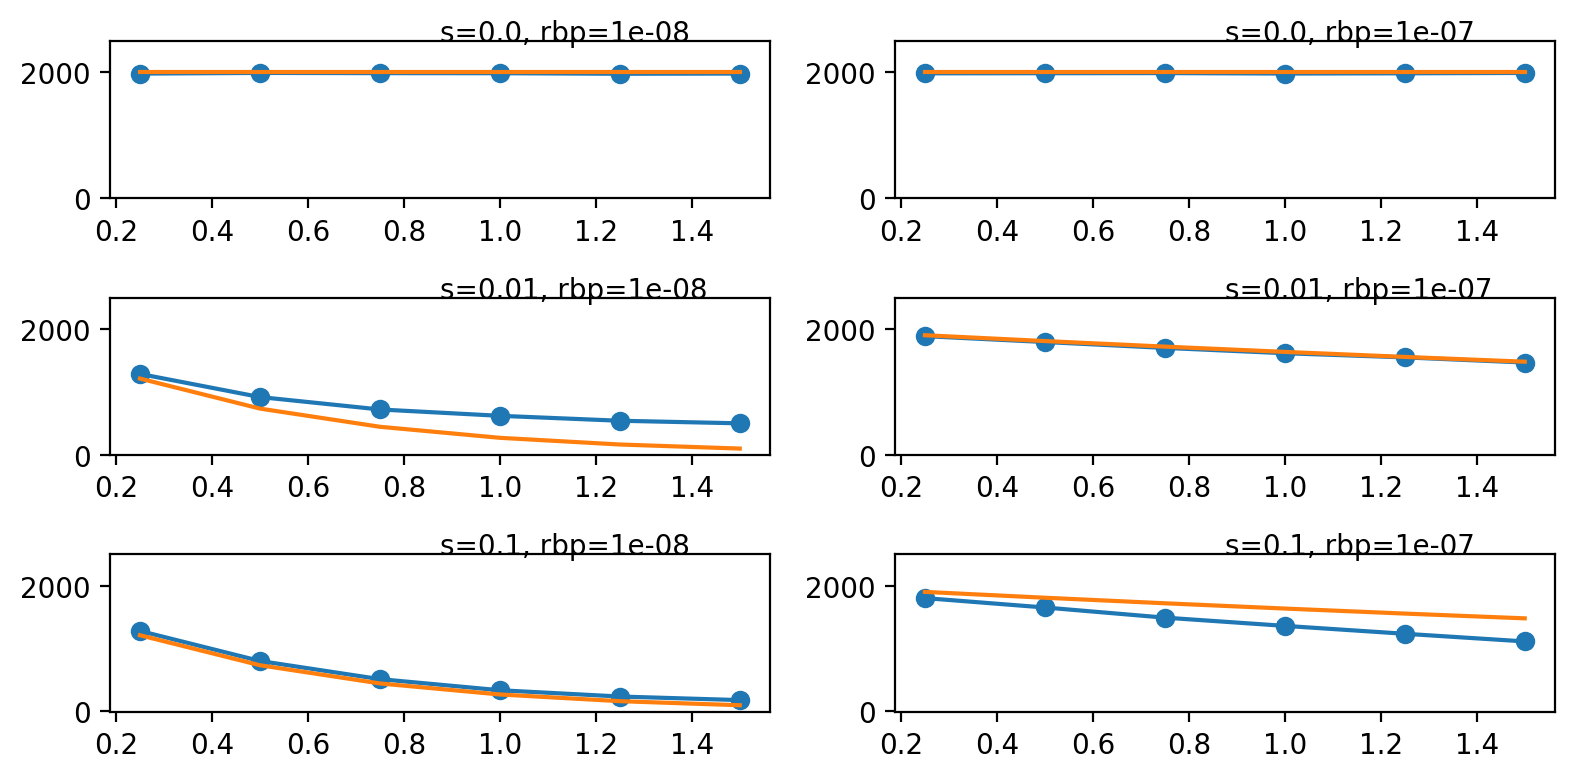

In [9]:
ss, rbps = sorted(bgssum['s'].unique()), sorted(bgssum['rbp'].unique())

fig, ax = plt.subplots(len(ss), len(rbps), sharey='col')

@np.vectorize
def HK95(μ, N, L, U):
    return 4 * μ * N * np.exp(-U / L)

for i, s in enumerate(ss):
    for j, rbp in enumerate(rbps):
        d = bgssum[(bgssum['rbp'] == rbp) & (bgssum['s'] == s)]

        nmu = d['nmu'].unique()
        rl = d['region_length'].unique()
        N = d['N'].unique()
        L = rbp * rl
        U = d['U'].unique()
        
        assert(len(nmu) == 1 and len(rl) == 1 and len(N) == 1) 
        
        ax[i, j].plot(d['U'], d['neut_het'], '-o')
        ax[i, j].text(0.5, 1, f"s={s}, rbp={rbp}", transform=ax[i, j].transAxes)
        ssh = HK95(nmu * rl, N, L, U) if s > 0 else np.repeat(4 * N * nmu * rl, len(U))
        ax[i, j].plot(d['U'], ssh)
        ax[i, j].set_ylim(-1, 2.5e3)
plt.tight_layout()

## Comparision of Total Variance

### N = 1000

In [10]:
neut_files_1e3N = sorted(glob.glob(datadir + "bgs_1000N_1e-08rbp_0s_1e-08nmu_1U_*_neutfreqs.tsv"))[0:20]
bgs_files_1e3N = sorted(glob.glob(datadir + "bgs_1000N_1e-08rbp_0.1s_1e-08nmu_1U_*_neutfreqs.tsv"))[0:20]
weak_bgs_files_1e3N = sorted(glob.glob(datadir + "bgs_1000N_1e-08rbp_0.01s_1e-08nmu_1U_*_neutfreqs.tsv"))[0:20]

In [11]:
def freqs_for_cov(frqs, burnin = 10000, gens=150, with_G=True, fixed_to_nan=False):
    use_masked = fixed_to_nan
    idx = np.array([i for i, time in enumerate(frqs.samples) if 
                    burnin <= time <= burnin + gens])
    samples = [(0, time) for time in idx]
    freqmat = frqs.freqs[idx, :]
    if fixed_to_nan:
        freqmat[np.logical_or(freqmat == 0., freqmat == 1.)] = np.nan
    d = TemporalFreqs(freqmat, samples)
    if with_G:
        return d.calc_cov(use_masked=use_masked), d.calc_G(use_masked=use_masked)
    return d.calc_cov(use_masked=use_masked)

def covs_from_file(file, *args, **kwargs):
    return freqs_for_cov(sf.parse_slim_ragged_freqs(file), *args, **kwargs)


In [12]:
pool = Pool(processes=10)

In [13]:
#bgs_covs = [freqs_for_cov(sf.parse_slim_ragged_freqs(f)) for f in bgs_files]
bgs_covs_1e3N = pool.map(covs_from_file, bgs_files_1e3N)

In [ ]:
#weak_bgs_covs = [freqs_for_cov(sf.parse_slim_ragged_freqs(f)) for f in weak_bgs_files]
weak_bgs_covs_1e3N = pool.map(covs_from_file, weak_bgs_files_1e3N)

In [ ]:
#neut_covs = [freqs_for_cov(sf.parse_slim_ragged_freqs(f)) for f in neut_files]
neut_covs_1e3N = pool.map(covs_from_file, neut_files_1e3N)

In [ ]:
G_bgs_1e3N = [g for _, g in bgs_covs_1e3N]
G_weak_bgs_1e3N = [g for _, g in weak_bgs_covs_1e3N]
G_neut_1e3N = [g for _, g in neut_covs_1e3N]

for i, g in enumerate(G_weak_bgs_1e3N):
    lab = "BGS, s=0.01" if i == 0 else ""
    plt.plot(g, c='r', label=lab)

for i, g in enumerate(G_bgs_1e3N):
    lab = "BGS, s=0.1" if i == 0 else ""
    plt.plot(g, c='g', label=lab)

for i, g in enumerate(G_neut_1e3N):
    lab = "neut" if i == 0 else ""
    plt.plot(g, c='b', label=lab)

plt.ylabel('G')
plt.xlabel('generations')
plt.axhline(0)
plt.ylim(-1, 1)
plt.legend(frameon=False)

### With N = 100

With N = 100, fixations occur over a very short timescale. As such, this leads to negative covariance, an artifact of the method, when one does not mark fixations and losses as NaNs. Thus, below we use remove these. 

Note that one also needs to ignore fixed sites when calculating the level of variance for inferring Ne. In this case, fixed/loss sites have allele frequency change zero, and shrink the value towards zero.



In [ ]:
neut_files_1e2N = sorted(glob.glob(datadir + "bgs_100N_1e-08rbp_0s_1e-08nmu_1U_*_neutfreqs.tsv"))[0:20]
bgs_files_1e2N = sorted(glob.glob(datadir + "bgs_100N_1e-08rbp_0.1s_1e-08nmu_1U_*_neutfreqs.tsv"))[0:20]
weak_bgs_files_1e2N = sorted(glob.glob(datadir + "bgs_100N_1e-08rbp_0.01s_1e-08nmu_1U_*_neutfreqs.tsv"))[0:20]

In [ ]:
pool = Pool(processes=10)

In [ ]:
# a temporary wrapper for these parameters
covs_from_file_wrapped = partial(covs_from_file, burnin=1000, fixed_to_nan=True)

bgs_covs_1e2N = pool.map(covs_from_file_wrapped, bgs_files_1e2N)

In [ ]:
weak_bgs_covs_1e2N = pool.map(covs_from_file_wrapped, weak_bgs_files_1e2N)

In [ ]:
neut_covs_1e2N = pool.map(covs_from_file_wrapped, neut_files_1e2N)

In [ ]:
G_bgs_1e2N = [g for _, g in bgs_covs_1e2N]
G_weak_bgs_1e2N = [g for _, g in weak_bgs_covs_1e2N]
G_neut_1e2N = [g for _, g in neut_covs_1e2N]

for i, g in enumerate(G_weak_bgs_1e2N):
    lab = "BGS, s=0.01" if i == 0 else ""
    plt.plot(g, c='r', label=lab)

for i, g in enumerate(G_bgs_1e2N):
    lab = "BGS, s=0.1" if i == 0 else ""
    plt.plot(g, c='g', label=lab)

for i, g in enumerate(G_neut_1e2N):
    lab = "neut" if i == 0 else ""
    plt.plot(g, c='b', label=lab)

plt.ylabel('G')
plt.xlabel('generations')
plt.axhline(0)
plt.ylim(-1, 1)
plt.legend(frameon=False)

### Without removing fixations

In [ ]:
# a temporary wrapper for these parameters
covs_from_file_wrapped_withfix = partial(covs_from_file, burnin=1000, fixed_to_nan=False)

bgs_covs_1e2N_fix = pool.map(covs_from_file_wrapped_withfix, bgs_files_1e2N)

In [ ]:
weak_bgs_covs_1e2N_fix = pool.map(covs_from_file_wrapped_withfix, weak_bgs_files_1e2N)

In [ ]:
neut_covs_1e2N_fix = pool.map(covs_from_file_wrapped_withfix, neut_files_1e2N)

In [ ]:
G_bgs_1e2N_fix = [g for _, g in bgs_covs_1e2N_fix]
G_weak_bgs_1e2N_fix = [g for _, g in weak_bgs_covs_1e2N_fix]
G_neut_1e2N_fix = [g for _, g in neut_covs_1e2N_fix]

for i, g in enumerate(G_weak_bgs_1e2N_fix):
    lab = "BGS, s=0.01" if i == 0 else ""
    plt.plot(g, c='r', label=lab)

for i, g in enumerate(G_bgs_1e2N_fix):
    lab = "BGS, s=0.1" if i == 0 else ""
    plt.plot(g, c='g', label=lab)

for i, g in enumerate(G_neut_1e2N_fix):
    lab = "neut" if i == 0 else ""
    plt.plot(g, c='b', label=lab)

plt.ylabel('G')
plt.xlabel('generations')
plt.axhline(0)
plt.ylim(-1, 1)
plt.legend(frameon=False)

This shows how much processing fixations differently can affect things.

Maybe, replace fixations with NaNs, the sites contributiong to the long run covariances are those with really long fixation times. This implies they must have more "balanced" drifts – maybe this creates negative covariance? 

In [ ]:
G_bgs = [g for _, g in bgs_covs]
G_weak_bgs = [g for _, g in weak_bgs_covs]
G_neut = [g for _, g in neut_covs]

for i, g in enumerate(G_weak_bgs):
    lab = "BGS, s=0.01" if i == 0 else ""
    plt.plot(g, c='r', label=lab)

for i, g in enumerate(G_bgs):
    lab = "BGS, s=0.1" if i == 0 else ""
    plt.plot(g, c='g', label=lab)

for i, g in enumerate(G_neut):
    lab = "neut" if i == 0 else ""
    plt.plot(g, c='b', label=lab)

plt.ylabel('G')
plt.xlabel('generations')
plt.axhline(0)

plt.legend(frameon=False)

In [158]:
print(f"s = 0.1, mean vars = {np.round(np.sum([np.diag(c).mean() for c, g in bgs_covs]), 3)}\n" + 
  covs_from_file = 0.01, mean vars = {np.round(np.sum([np.diag(c).mean() for c, g in weak_bgs_covs]),3)}\n" + 
      f"s = 0.00, mean vars = {np.round(np.sum([np.diag(c).mean() for c, g in neut_covs]),3)}")

s = 0.1, mean vars = 0.038
s = 0.01, mean vars = 0.023
s = 0.00, mean vars = 0.009


In [159]:
print(
f"s = 0.1, mean sum of covs = {np.round(np.mean([c[np.triu_indices(c.shape[1], k=1)].sum() for c, g in bgs_covs]), 4)}\n" + 
f"s = 0.01, mean sum of covs = {np.round(np.mean([c[np.triu_indices(c.shape[1], k=1)].sum() for c, g in weak_bgs_covs]), 4)}\n" + 
f"s = 0.00, mean sum of covs = {np.round(np.mean([c[np.triu_indices(c.shape[1], k=1)].sum() for c, g in neut_covs]), 4)}")


s = 0.1, mean sum of covs = 0.0504
s = 0.01, mean sum of covs = 0.0122
s = 0.00, mean sum of covs = 0.0002


```
# sum of diagonals (variances), averaged across replicates
s = 0.1, mean vars = 0.038
s = 0.01, mean vars = 0.023
s = 0.00, mean vars = 0.009

# sum of upper triangle (covariances), averaged across replicates
s = 0.1, mean sum of covs = 0.0504
s = 0.01, mean sum of covs = 0.0122
s = 0.00, mean sum of covs = 0.0002

```

In [167]:
(0.5 * 60) / 0.009

3333.3333333333335